In [64]:
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plot

from collections import defaultdict

from surprise.model_selection import train_test_split
from surprise import Reader, Dataset, SVD, accuracy

In [2]:
df = pd.read_csv("ratings_Electronics.csv")

In [3]:
df.head()

,AKM1MP6P0OYPR,132793040,5,1365811200
0,A2CX7LUOHB2NDG,321732944,5,1341100800
1,A2NWSAGRHCP8N5,439886341,1,1367193600
2,A2WNBOD3WNDNKT,439886341,3,1374451200
3,A1GI0U4ZRJA8WN,439886341,1,1334707200
4,A1QGNMC6O1VW39,511189877,5,1397433600


In [4]:
#adding column name
df.columns =['UserId', 'ProductId', 'Rating', 'TimeStamp'] 

In [5]:
df.shape

(1048575, 4)

In [6]:
#No column has null
df.isnull().count()

UserId       1048575
ProductId    1048575
Rating       1048575
TimeStamp    1048575
dtype: int64

In [7]:
#count of distinct product
df.ProductId.nunique()

61893

In [8]:
#count of distinct userid
df.UserId.nunique()

786329

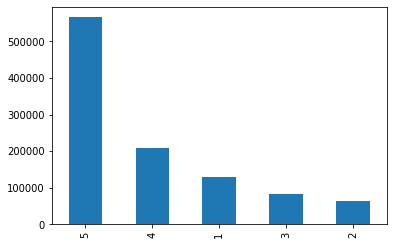

In [10]:
#Plotting the rating
df.Rating.value_counts().plot(kind='bar')

In [24]:
#Getting user who have rated very less times
df.groupby('UserId')['Rating'].count().sort_values(ascending=True).head()  

UserId
A00037441I8XOQJSUWCAG    1
A3EEUT0F9898GS           1
A3EEUZUBZQ4N4D           1
A3EEVD827ZC4JY           1
A3EEW1G63825UL           1
Name: Rating, dtype: int64

In [25]:
#Getting only users with minimum 50 ratings
min_rating_users = df.groupby('UserId').agg({'Rating':[np.size]})
min_rating_users.head()

,Rating
,size
UserId,
A00037441I8XOQJSUWCAG,1
A00038802J7X43YTW44TD,2
A000428226SAAAIBK8I36,1
A0004478EF5NFPHLGCWG,1
A000681618A3WRMCK53V,1


In [26]:
#users who have rated the products more than 50
top_users = min_rating_users['Rating']['size']>=50

In [27]:
#getting top users in descending order of number of times they did the rating
min_rating_users[top_users].sort_values([('Rating','size')],ascending=False)[:15]

,Rating
,size
UserId,
A5JLAU2ARJ0BO,412
A231WM2Z2JL0U3,249
A25HBO5V8S8SEA,164
A6FIAB28IS79,146
AT6CZDCP4TRGA,128
AKT8TGIT6VVZ5,122
A11D1KHM7DVOQK,112
A2B7BUH8834Y6M,103


In [28]:
#finally the dataframe with user id and rating of the top users
top_rated = pd.merge(df, min_rating_users[top_users], on='UserId', how='inner')

C:\Users\sumans\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:522: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [30]:
top_rated.head()

,UserId,ProductId,Rating,TimeStamp,"(Rating, size)"
0,A5JLAU2ARJ0BO,1400532655,1,1291334400,412
1,A5JLAU2ARJ0BO,B00003006R,5,1052092800,412
2,A5JLAU2ARJ0BO,B00003G1RG,3,1104796800,412
3,A5JLAU2ARJ0BO,B00004S9AK,5,956880000,412
4,A5JLAU2ARJ0BO,B00004SB92,4,1034726400,412


In [34]:
#Getting how many ratings has been given on Products
top_rated.groupby('ProductId')['Rating'].count().sort_values(ascending=False).head()  

ProductId
B00004SB92    7
B00004ZCJE    5
B00008OE6I    5
B00005LEN4    5
B00007KDVI    5
Name: Rating, dtype: int64

In [35]:
#getting highly rated products with mean rating
top_rated.groupby('ProductId')['Rating'].mean().sort_values(ascending=False).head()  

ProductId
B0001FV3AK    5.0
B00009XW3F    5.0
B0000AOWWM    5.0
B00004ZCDD    5.0
B0000AQFZ9    5.0
Name: Rating, dtype: float64

In [36]:
ratings_mean_count = pd.DataFrame(top_rated.groupby('ProductId')['Rating'].mean()) 

In [37]:
ratings_mean_count['rating_counts'] = pd.DataFrame(top_rated.groupby('ProductId')['Rating'].count()) 

#### Popular Products

In [38]:
#Popular Products
ratings_mean_count.sort_values(by=['Rating','rating_counts'],ascending=False).head()

,Rating,rating_counts
ProductId,,
B00004Z5M1,5.0,4
B0007QKMQY,5.0,4
B000BY52NK,5.0,4
B000050AQ7,5.0,3
B00005LENO,5.0,3


#### Collaborative Filtering model

In [45]:
#Spliting the data in 70:30 ratio
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(top_rated[['UserId', 'ProductId', 'Rating']], reader)
trainset, testset = train_test_split(data, test_size=.30)


In [65]:
#building user base colab filter
algo = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': True},n_factors=50)
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [66]:
test_pred = algo.test(testset)

In [73]:
test_pred

[Prediction(uid='A1FR68QH6Z4YZM', iid='B0009EUSYU', r_ui=5.0, est=4.225713104588673, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A2XRMQA6PJ5ZJ8', iid='B000F2YHRA', r_ui=4.0, est=4.225713104588673, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A7Y6AVS576M03', iid='B000EP1IL6', r_ui=5.0, est=4.225713104588673, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A5JLAU2ARJ0BO', iid='B0007N55MS', r_ui=5.0, est=4.225713104588673, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A5JLAU2ARJ0BO', iid='B000092YQW', r_ui=1.0, est=4.225713104588673, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A2R6RA8FRBS608', iid='B0009RO5VO', r_ui=5.0, est=4.225713104588673, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A25HBO5V8S8SEA', iid

In [67]:
#evaluating the model
print("User-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

User-based Model : Test Set
RMSE: 1.1231


1.123104914771135

In [70]:
def get_top_n(predictions, n=5):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [71]:
3Top 5 recommendation
top_n = get_top_n(test_pred, n=5)
top_n

defaultdict(list,
            {'A1FR68QH6Z4YZM': [('B00020KPB2', 5),
              ('B00005LEN4', 5),
              ('B00005LE77', 4.686274509803922),
              ('B000BY52NK', 4.686274509803922),
              ('B000094FV6', 4.686274509803922)],
             'A2XRMQA6PJ5ZJ8': [('B000HZDF8W', 4.634146341463414),
              ('B00005T3HO', 4.634146341463414),
              ('B000IF4788', 4.634146341463414),
              ('B000BY52NK', 4.634146341463414),
              ('B0001CNMFM', 4.634146341463414)],
             'A7Y6AVS576M03': [('B00001YVG4', 5),
              ('B0001GYAA4', 4.73469387755102),
              ('B000AJIF4E', 4.73469387755102),
              ('B000EP1IL6', 4.225713104588673),
              ('B00005AY9I', 4.225713104588673)],
             'A5JLAU2ARJ0BO': [('B0007QKMQY', 5),
              ('B00008WFVI', 4.578727915194346),
              ('B0007N55MS', 4.225713104588673),
              ('B000092YQW', 4.225713104588673),
              ('B00015GYU4', 4.2257131045886

In [72]:
#### Insight

In [74]:
print('Matrix formed is very sparsed, for most of the user, model is not able to find the nearest neighbours hence the prediction is not correct.')
print('RMSE is around 1.2')

Matrix formed is very sparsed, for most of the user, model is not able to find the nearest neighbours hence the prediction is not correct.
RMSE is around 1.2
